In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/wpan03/quick_ds_python.git
    !mv quick_ds_python/* .
    !pip install treeinterpreter==0.2.3
else:
    %load_ext autoreload
    %autoreload 2

Cloning into 'quick_ds_python'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 221 (delta 116), reused 156 (delta 64), pack-reused 0
Receiving objects: 100% (221/221), 430.62 KiB | 2.89 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from src.eda import see_missing, plot_corr_heatmap, get_freq_table
from src.preprocess import get_x_y, get_preprocessor, do_transform
from src.evaluate import binary_evaluation, binary_cross_evaluate
from src.explain import (get_feature_imp, get_permute_imp_df, plot_permute_imp,
                         get_binary_error_analysis, plot_single_instance_explaination)
from src.model_supervised import find_dt_clf_max_depth


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/wpan03/quick_ds_python/master/data/titanic_train.csv')

## EDA

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape

(891, 12)

In [6]:
see_missing(df, only_missing=True)

,columns,total_missing,percent_missing
0,Cabin,687,77.104377
1,Age,177,19.865320
2,Embarked,2,0.224467


In [7]:
plot_corr_heatmap(df)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


In [8]:
get_freq_table(df, 'Survived')

,count,percentage
0,549,0.616162
1,342,0.383838


In [9]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
model_vars = ['Pclass', 'Sex', 'Age', 'Fare', 'Survived']

## Preprocess

### Train and Test Split

In [11]:
df_mod = df[model_vars]

In [12]:
X, y = get_x_y(df_mod, label_col='Survived')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)

### Encode and Impute

In [14]:
oh_enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
med_imp = SimpleImputer(strategy='median')

In [15]:
preprocessor = get_preprocessor(oh_enc, med_imp)
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f856204e2d0>),
                                ('simpleimputer',
                                 SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               missing_values=nan,
                                               strategy='median', verbose=0),
                                 <sklearn.compose._column_transformer.make_column_selector

In [16]:
_ = preprocessor.fit(X)

In [17]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names()) + preprocessor.transformers_[1][2]
col_names

['x0_female', 'x0_male', 'Pclass', 'Age', 'Fare']

In [18]:
X_train_prepared = do_transform(X_train, preprocessor, col_names)
X_test_prepared = do_transform(X_test, preprocessor, col_names)

## Fit Model

In [19]:
mod_rf = RandomForestClassifier(random_state=36)

In [20]:
_ = mod_rf.fit(X_train_prepared, y_train)

In [21]:
binary_evaluation(X_train_prepared, y_train, mod_rf)

,metrics,value
0,accuracy,0.979042
1,balanced acc,0.974569
2,precision,0.987705
3,recall,0.956349
4,f1,0.971774


In [22]:
binary_cross_evaluate(X_train_prepared, y_train, mod_rf)

,fit_time,score_time,test_accuracy,test_f1
0,0.168373,0.014469,0.820628,0.759036
1,0.164469,0.012713,0.802691,0.725000
2,0.167894,0.012348,0.743243,0.645963


## Error Analysis

In [23]:
get_binary_error_analysis(X_test_prepared, y_test, mod_rf, only_show_error=True).head(5)

,x0_female,x0_male,Pclass,Age,Fare,class1_prob,pred_class,actual_class,loss
0,0.0,1.0,2.0,62.0,10.5000,0.00,0,1,18.420681
1,1.0,0.0,1.0,25.0,151.5500,1.00,1,0,18.420681
2,1.0,0.0,3.0,28.0,7.8958,1.00,1,0,18.420681
3,1.0,0.0,2.0,44.0,26.0000,0.99,1,0,4.605170
4,0.0,1.0,3.0,20.0,15.7417,0.01,0,1,4.605170


## Explain the Model

### Random Forest Feature Importance

In [24]:
get_feature_imp(X_train_prepared, mod_rf)

,name,score
0,Fare,0.335916
1,Age,0.290966
2,x0_male,0.144306
3,x0_female,0.123453
4,Pclass,0.105359


### Permutation Feature Importance

In [25]:
df_permute, permute_result = get_permute_imp_df(mod_rf, X_test_prepared, y_test, return_full_result=True)

In [26]:
df_permute

,name,importance_mean,importance_std
0,x0_male,0.113004,0.012166
1,Pclass,0.109417,0.006083
2,Age,0.067265,0.015273
3,Fare,0.056502,0.007819
4,x0_female,0.051121,0.016193


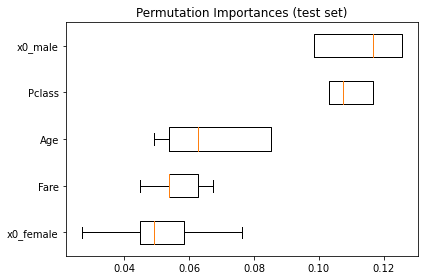

In [27]:
plot_permute_imp(X_test_prepared, permute_result)

### Surrogate Tree

In [28]:
y_train_surr = mod_rf.predict(X_train_prepared)

In [29]:
cv_dt_acc = find_dt_clf_max_depth(X_train_prepared, y_train, max_depth_range=range(1, 20))
cv_dt_acc

array([0.77688226, 0.77538076, 0.80083896, 0.8127971 , 0.78884041,
       0.79483295, 0.78590474, 0.77538076, 0.77388599, 0.779892  ,
       0.77241142, 0.76341588, 0.75595551, 0.75745701, 0.75146447,
       0.75146447, 0.74995623, 0.74995623, 0.74995623])

In [30]:
mod_dt_surr = DecisionTreeClassifier(max_depth=3).fit(X_train_prepared, y_train_surr)

In [31]:
mod_dt_surr

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

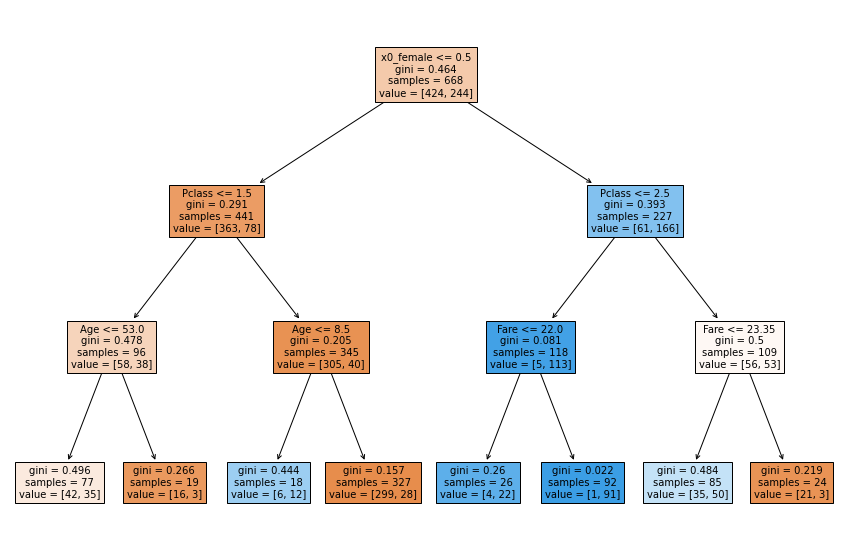

In [32]:
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(mod_dt_surr, feature_names=X_test_prepared.columns, filled=True, fontsize=10)

### Tree Interpreter

In [33]:
instance = X_test_prepared.iloc[[18], :]
instance

,x0_female,x0_male,Pclass,Age,Fare
18,0.0,1.0,1.0,61.0,33.5


In [34]:
plot_single_instance_explaination(mod_rf, instance)